In [22]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
import itertools
from sklearn.metrics import mean_absolute_error as mae
import random
from random import randint
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
import copy

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Correction Functions

In [23]:
def correct_apac(df_in, hour_range=(5,19)):
    
    df_apac = df_in.copy()
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    df_apac = df_apac[df_apac['hora(utc)'].isin(range(hour_range[0], hour_range[1]))]
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
        
    return df_apac

def correct_inmet(df_in, hour_range=(5,19)):
    
    df_inmet = df_in.copy()
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
        
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))
    
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')

    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    
    df_inmet = df_inmet[df_inmet['hora'].isin(range(hour_range[0], hour_range[1]))]
    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
     
    return df_inmet

def correct_gen(df_in, hour_range=(5,19)):
    
    df_gen = df_in.copy()
    df_gen['HoraInt'] = df_gen.Hora.apply(lambda x: int(x.hour))
    df_gen = df_gen[df_gen['HoraInt'].isin(range(hour_range[0], hour_range[1]))]
    df_gen.drop(['HoraInt'], inplace=True, axis=1)
    
    return df_gen


# Load and Process Data

In [24]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "maceio_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 360*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object


# SARIMAX 

## Auto arima

In [5]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-23432.718, Time=82.42 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-18470.751, Time=1.80 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-20397.215, Time=56.51 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-19531.827, Time=62.45 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-18472.751, Time=2.36 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-19530.747, Time=79.47 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-20923.301, Time=87.98 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-22980.044, Time=396.49 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-23212.262, Time=397.40 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-18541.966, Time=14.01 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-20059.566, Time=365.97 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-22286.276, Time=378.77 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=409.48 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Tim

MemoryError: Unable to allocate 178. MiB for an array with shape (52, 52, 8640) and data type float64

In [8]:
mod = SARIMAX(endog=gen, exog=exog, order=(3,1,2), seasonal_order=(1,0,1, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AIC: {0}, Mape: {1}".format(results.aic, mape_autoarima))

AIC: -24749.420145547916, Mape: 13.028530002228463


## ACO Parametrization

In [23]:
p = d = q = [0, 1] #range(0, 2)
sp = sd = sq = [0, 1] #range(0, 2)
s = [12,24] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]
options_ACO={'antNumber':4, 'antTours':2, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_ACO = sarimax_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace),
                                   options_ACO=options_ACO, verbose=True)
mape_aco = MAPE(y_sarimax_ACO, gen)

Original search Space: [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [12, 24]]
search Space with Exog Possibilities:  [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [12, 24], range(0, 16)]
dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [12, 24], range(0, 16)]
Space Created:  [[ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0 12  1]
 [ 0  0  0 ...  0 12  2]
 ...
 [ 1  1  1 ...  1 24 13]
 [ 1  1  1 ...  1 24 14]
 [ 1  1  1 ...  1 24 15]]
number of Space Possibilities (rows):  2048


  0%|          | 0/2 [00:00<?, ?it/s]

Setting fitness for
[ 1  0  0  1  1  0 24  3]
fitness is
-21312.224355026956
Setting fitness for
[ 1  0  1  0  0  0 24 13]
fitness is
-17935.65888124994
Setting fitness for
[ 1  1  0  1  0  0 12 13]
fitness is
-17892.45981012914
Setting fitness for
[ 1  1  0  1  1  1 24 11]
fitness is
-20915.41327573982
Setting fitness for
[ 1  0  0  0  1  0 12  7]
fitness is
-12065.73555787258
Setting fitness for
[ 0  0  0  0  1  0 24  8]
fitness is
-16773.065551582484
Setting fitness for
[ 1  1  0  0  1  1 12  9]
fitness is
-16669.166158186683
Setting fitness for
[ 1  0  1  0  1  1 12  9]
fitness is
-16743.309339580424
Dij: 
[[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
Tij: 
[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.

 50%|█████     | 1/2 [04:05<04:05, 245.19s/it]

Ant 0 possibilities:
[1309]
Ant 0 move from 1235 to 1309
Ant 1 possibilities:
[1787]
Ant 1 move from 1677 to 1787
Ant 2 possibilities:
[88]
Ant 2 move from 1095 to 88
Ant 3 possibilities:
[1385]
Ant 3 move from 1641 to 1385
Dij: 
[[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
Tij: 
[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 ...
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
Pij:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Ants now - then
[1309 1787   88 1385] - [1235 1677 1095 1641]
Setting fitness for
[ 1  0  1  0  0  0 24 13]
fitness is
-17935.65888124994
Setting fitness for
[ 1  0  1  1  0  1 24  3]

100%|██████████| 2/2 [09:30<00:00, 285.08s/it]

Pij:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Ant 0 possibilities:
[1235 1459]
Ant 0 move from 1309 to 1459
Ant 1 possibilities:
[  44 1677]
Ant 1 move from 1787 to 44
Ant 2 possibilities:
[1095 1533]
Ant 2 move from 88 to 1095
Ant 3 possibilities:
[ 710 1641]
Ant 3 move from 1385 to 710
Dij: 
[[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
Tij: 
[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]
Pij:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan

BEST result: 
 PDQ-parameters: [1 0 1] 
 PDQS-parameters: [ 1  0  1 24] 
 Exgoneous Var: [1, 1]


## PSO Parametrization

In [22]:
p = d = q = [0, 1, 2] #range(0, 2)
sp = sd = sq = [0, 1, 2] #range(0, 2)
s = [12,24] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]
options_PSO = {'n_particles':5,'n_iterations':2,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
y_sarimax_PSO = sarimax_PSO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, verbose=False)
mape_pso = MAPE(y_sarimax_PSO, gen)

2021-01-02 14:09:11,138 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.global_best:   0%|          |0/2

Original search Space: [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 2]]
search Space with Exog Possibilities:  [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 2], range(0, 16)]
PSO boundaries:  [0. 0. 0. 0. 0. 0. 0. 0.] [2, 2, 2, 2, 2, 2, 2, 15]
number of Space Possibilities (rows):  1920


pyswarms.single.global_best: 100%|██████████|2/2, best_cost=-2.42e+4
2021-01-02 14:24:03,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -24235.383127462446, best pos: [1.80233825 1.69736531 1.27456644 0.03023972 1.31721326 1.01257813
 1.01274242 8.59998901]


BEST result [1.80233825 1.69736531 1.27456644 0.03023972 1.31721326 1.01257813
 1.01274242 8.59998901]: 
 PDQ-parameters: [1 1 1] 
 SPDQ-parameters: [ 0  1  1 24] 
 Exgoneous Var: [1, 0, 0, 0]


## PSO-ACO Parametrization

In [16]:
p = d = q = [0, 1] #range(0, 2)
sp = sd = sq = [0, 1] #range(0, 2)
s = [12,24] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':10,'n_iterations':2,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':1, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)

2021-01-02 00:37:57,129 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.global_best:   0%|          |0/2
  0%|          | 0/1 [00:00<?, ?it/s]

Original search Space: [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 2]]
search Space with Exog Possibilities:  [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 2], range(0, 16)]
PSO boundaries:  [0. 0. 0. 0. 0.] [1, 1, 1, 2, 15]
5
dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


All Best Response
[1 1 1]
All Best Response Fitness
-17944.650051532117
BEST result:  [1 1 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:11<00:00, 11.95s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17921.643418168573
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:21<00:00, 21.70s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17935.658990521533
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:19<00:00, 19.29s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17923.643396830397
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:13<00:00, 13.57s/it]


All Best Response
[1 0 0]
All Best Response Fitness
-17925.60424481297
BEST result:  [1 0 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:18<00:00, 18.61s/it]


All Best Response
[1 1 0]
All Best Response Fitness
-17929.13874090683
BEST result:  [1 1 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:13<00:00, 13.16s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17937.65888048189
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:16<00:00, 16.23s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17935.658990521533
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:21<00:00, 21.30s/it]


All Best Response
[1 1 0]
All Best Response Fitness
-17929.642274269863
BEST result:  [1 1 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:23<00:00, 23.12s/it]


All Best Response
[1 0 0]
All Best Response Fitness
-17925.604244939215
BEST result:  [1 0 0]


pyswarms.single.global_best:  50%|█████     |1/2, best_cost=-1.66
  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:24<00:00, 24.18s/it]


All Best Response
[1 1 1]
All Best Response Fitness
-17944.650051532117
BEST result:  [1 1 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:17<00:00, 17.91s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17921.643418168573
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:24<00:00, 24.69s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17935.658990521533
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:18<00:00, 18.86s/it]


All Best Response
[1 1 1]
All Best Response Fitness
-17944.650051532117
BEST result:  [1 1 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:11<00:00, 11.06s/it]


All Best Response
[1 1 0]
All Best Response Fitness
-17929.642274269863
BEST result:  [1 1 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


All Best Response
[1 1 0]
All Best Response Fitness
-17929.13874090683
BEST result:  [1 1 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:16<00:00, 16.55s/it]


All Best Response
[1 1 1]
All Best Response Fitness
-17944.650051532117
BEST result:  [1 1 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:20<00:00, 20.14s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17935.658990521533
BEST result:  [1 0 1]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


All Best Response
[1 1 0]
All Best Response Fitness
-17929.42834614183
BEST result:  [1 1 0]



  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[0, 1], [0, 1], [0, 1]]
Space Created:  [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
number of Space Possibilities (rows):  8



100%|██████████| 1/1 [00:25<00:00, 25.26s/it]


All Best Response
[1 0 1]
All Best Response Fitness
-17935.658990521533
BEST result:  [1 0 1]


pyswarms.single.global_best: 100%|██████████|2/2, best_cost=-1.66
2021-01-02 00:45:40,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.6566268467577885, best pos: [0.6326113  0.34297385 0.88089661 1.83922784 3.81778758]


Global best result:  (0.7944195033450152, array([1, 1, 0]), array([ 0,  0,  0, 12]), 9)


## DUMP Sarimax

In [9]:
y_sarimax = y_sarimax_auto
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

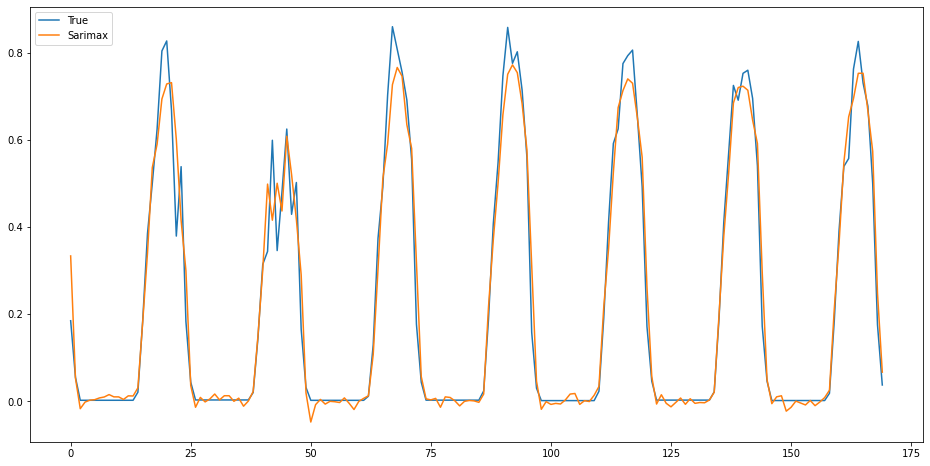

In [10]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

In [14]:
tr_ts_percents=[80,20]
ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
                                 tr_ts_percents=tr_ts_percents).search_best_model()
best_mlp_residual = ag_mlp_residual._best_of_all
pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0



100%|██████████| 3/3 [00:21<00:00,  7.30s/it]

100%|██████████| 3/3 [02:32<00:00, 50.77s/it]

100%|██████████| 3/3 [00:13<00:00,  4.53s/it]

100%|██████████| 3/3 [11:34<00:00, 231.61s/it]

100%|██████████| 3/3 [00:06<00:00,  2.24s/it]

100%|██████████| 3/3 [05:10<00:00, 103.52s/it]

100%|██████████| 3/3 [00:31<00:00, 10.44s/it]

100%|██████████| 3/3 [06:58<00:00, 139.39s/it]

100%|██████████| 3/3 [01:04<00:00, 21.58s/it]

100%|██████████| 3/3 [00:50<00:00, 16.79s/it]

100%|██████████| 3/3 [00:08<00:00,  2.93s/it]

100%|██████████| 3/3 [02:30<00:00, 50.25s/it]

100%|██████████| 3/3 [00:25<00:00,  8.55s/it]

100%|██████████| 3/3 [02:26<00:00, 48.79s/it]

100%|██████████| 3/3 [00:28<00:00,  9.44s/it]

100%|██████████| 3/3 [02:42<00:00, 54.00s/it]

100%|██████████| 3/3 [00:11<00:00,  3.85s/it]

100%|██████████| 3/3 [11:03<00:00, 221.33s/it]

100%|██████████| 3/3 [00:19<00:00,  6.58s/it]

100%|██████████| 3/3 [03:06<00:00, 62.31s/it]

100%|██████████| 3/3 [00:09<00:00,  3.10s/it]

100%|███

generation: 1



100%|██████████| 3/3 [00:35<00:00, 11.83s/it]

100%|██████████| 3/3 [13:04<00:00, 261.41s/it]

100%|██████████| 3/3 [00:05<00:00,  1.69s/it]

100%|██████████| 3/3 [04:40<00:00, 93.47s/it]

100%|██████████| 3/3 [00:17<00:00,  6.00s/it]

100%|██████████| 3/3 [00:34<00:00, 11.57s/it]

100%|██████████| 3/3 [00:15<00:00,  5.24s/it]

100%|██████████| 3/3 [02:04<00:00, 41.66s/it]

100%|██████████| 3/3 [00:08<00:00,  2.71s/it]

100%|██████████| 3/3 [01:22<00:00, 27.34s/it]

100%|██████████| 3/3 [00:18<00:00,  6.33s/it]

100%|██████████| 3/3 [10:26<00:00, 208.83s/it]

100%|██████████| 3/3 [00:24<00:00,  8.19s/it]

100%|██████████| 3/3 [02:06<00:00, 42.14s/it]

100%|██████████| 3/3 [00:18<00:00,  6.23s/it]

100%|██████████| 3/3 [06:04<00:00, 121.52s/it]

100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

100%|██████████| 3/3 [01:02<00:00, 20.78s/it]

100%|██████████| 3/3 [00:13<00:00,  4.53s/it]

 67%|██████▋   | 2/3 [2:06:16<1:07:36, 4056.54s/it]

generation: 2



100%|██████████| 3/3 [00:22<00:00,  7.57s/it]

100%|██████████| 3/3 [07:48<00:00, 156.03s/it]

100%|██████████| 3/3 [00:21<00:00,  7.16s/it]

100%|██████████| 3/3 [09:41<00:00, 193.68s/it]

100%|██████████| 3/3 [00:08<00:00,  2.83s/it]

100%|██████████| 3/3 [12:29<00:00, 249.81s/it]

100%|██████████| 3/3 [00:11<00:00,  3.79s/it]

100%|██████████| 3/3 [01:47<00:00, 35.67s/it]

100%|██████████| 3/3 [00:15<00:00,  5.26s/it]

100%|██████████| 3/3 [06:39<00:00, 133.28s/it]

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]

100%|██████████| 3/3 [03:54<00:00, 78.03s/it]

100%|██████████| 3/3 [00:30<00:00, 10.12s/it]

100%|██████████| 3/3 [00:40<00:00, 13.34s/it]

100%|██████████| 3/3 [00:10<00:00,  3.61s/it]

100%|██████████| 3/3 [2:59:09<00:00, 3583.16s/it]  


## Análise Resultados

[2, 18, 16, 12, MLPRegressor(activation='identity', hidden_layer_sizes=(42, 25, 8),
             learning_rate='adaptive', max_iter=500, solver='lbfgs'), MLPRegressor(activation='tanh', hidden_layer_sizes=(68, 16, 9), max_iter=500,
             solver='lbfgs'), 0.02429946787264627]
Teste para saber se pegou o melhor mesmo! 0.02429946787264627 == 0.02429946787264627 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.04118558734496845
MSE:  0.004654832697843107
MAPE:  2.365371024865486
HIBRIDO
MAE:  0.02429946787264627
MSE:  0.0015344057676281145
MAPE:  1.5869695413703095
GANHO MAE:
0.410000695895991
GANHO MSE:
0.6703628535695587
GANHO MAPE:
0.3290821927352571


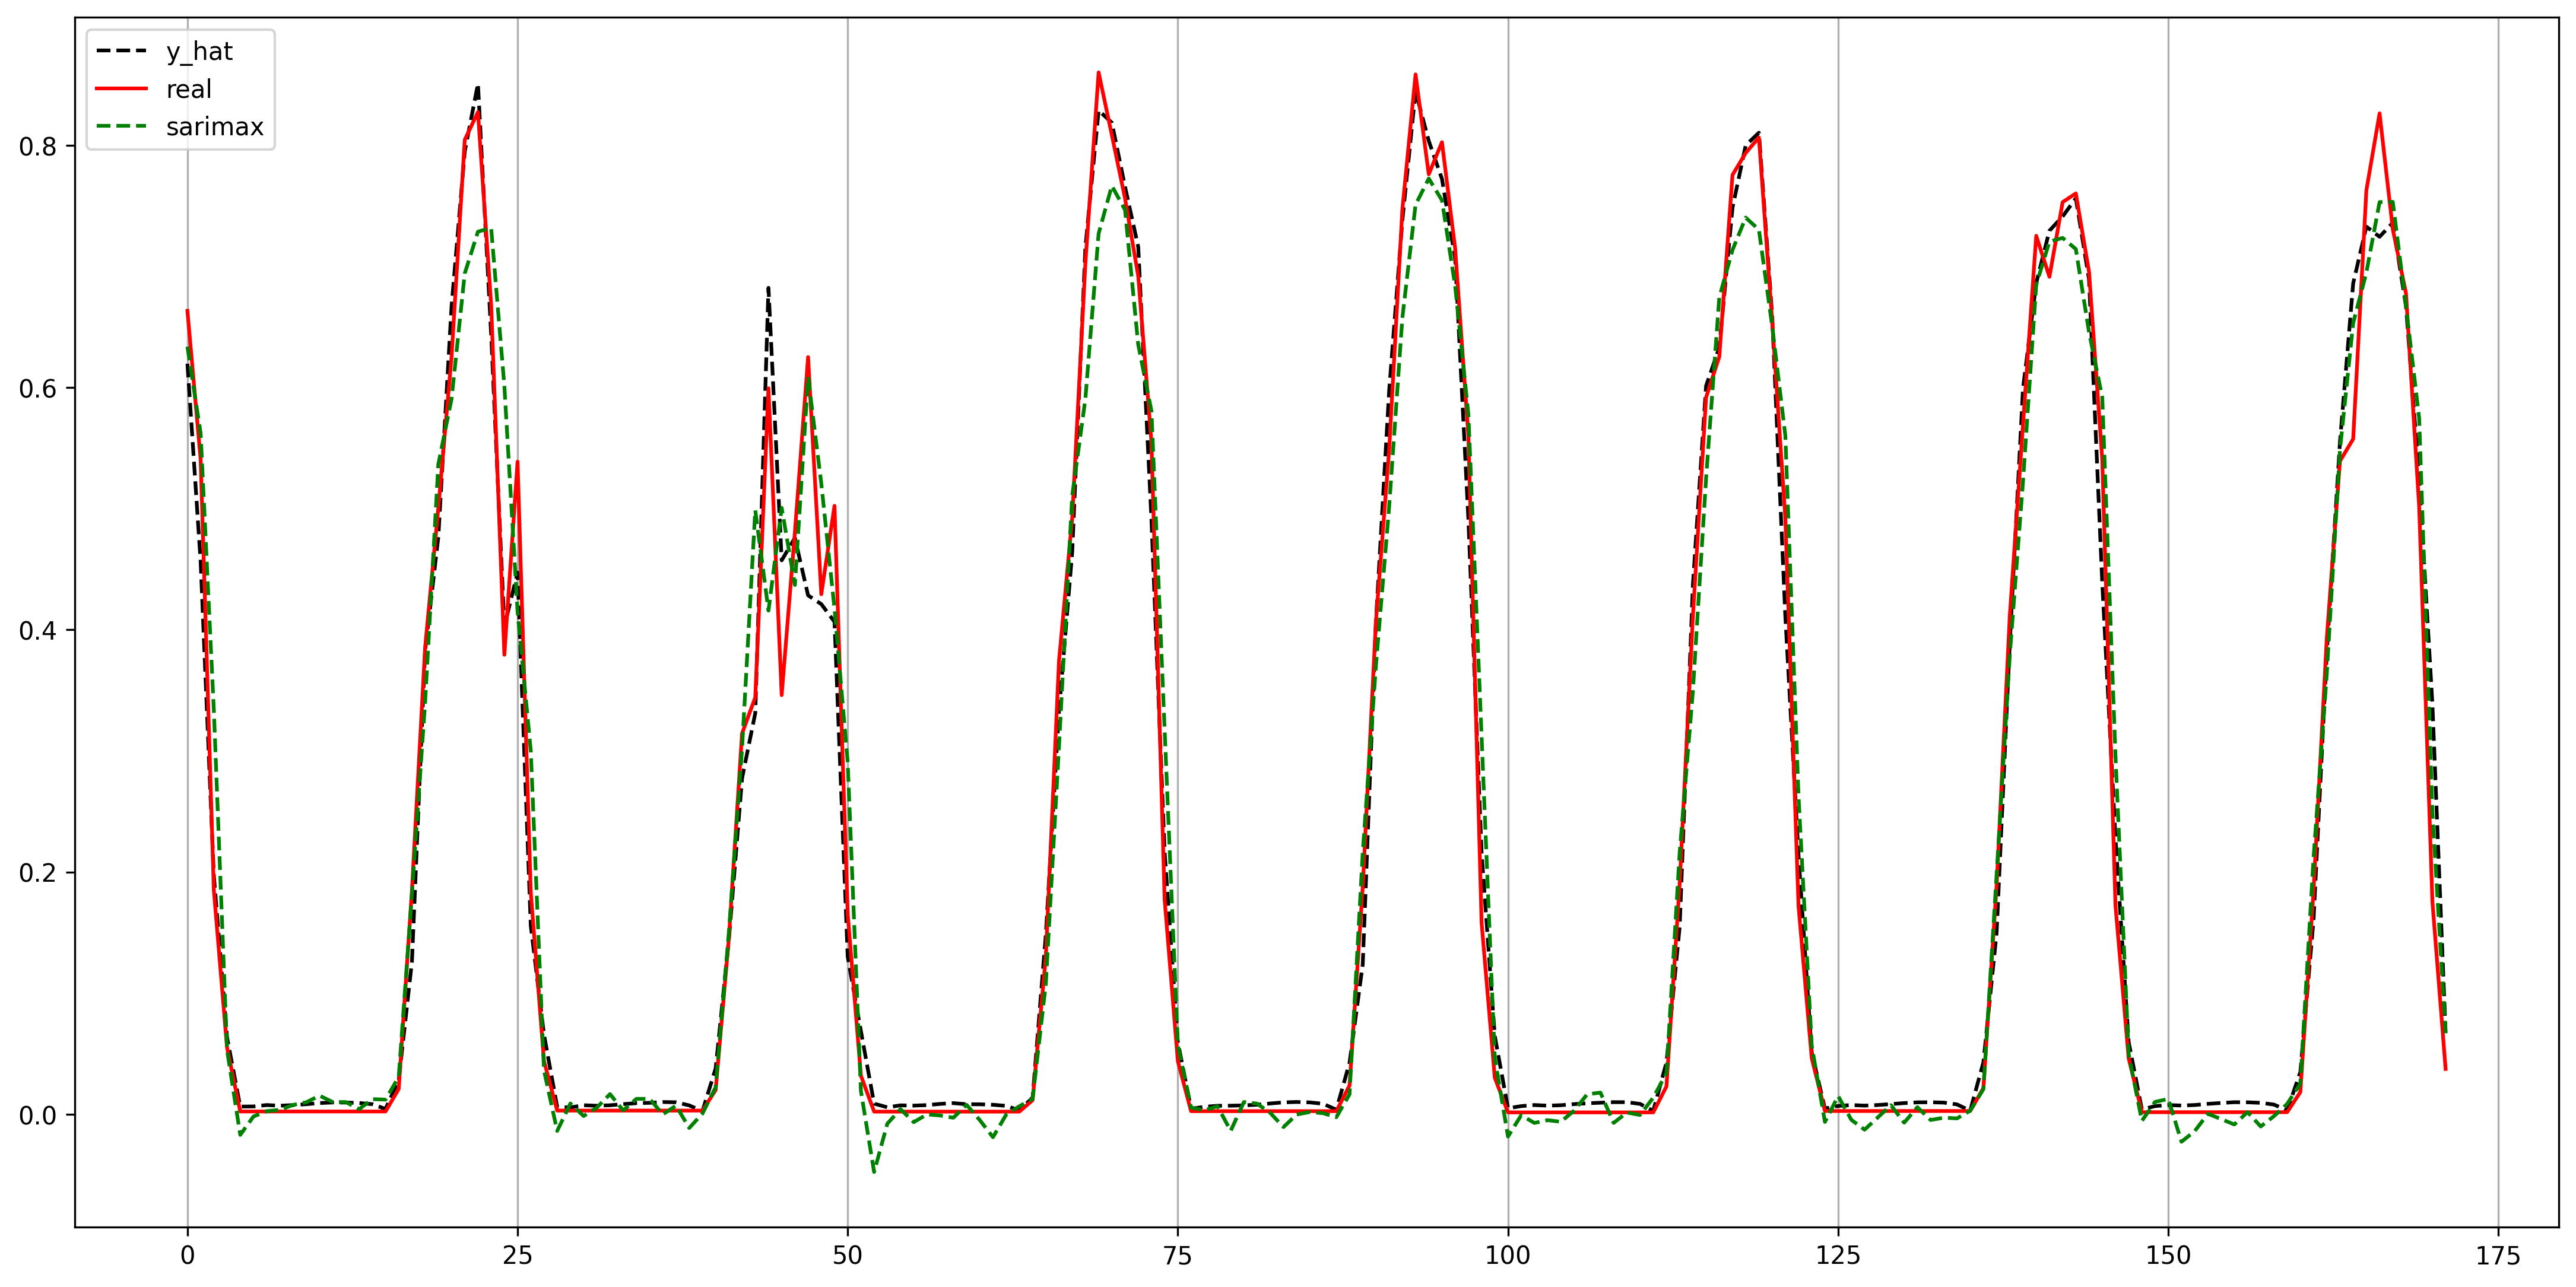

In [15]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('J/M2', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

In [16]:
tr_ts_percents=[80,20]
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
                                       prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0



100%|██████████| 3/3 [00:11<00:00,  3.89s/it]

100%|██████████| 3/3 [01:33<00:00, 31.05s/it]

100%|██████████| 3/3 [00:20<00:00,  6.69s/it]

100%|██████████| 3/3 [02:44<00:00, 54.98s/it]

100%|██████████| 3/3 [00:14<00:00,  4.76s/it]

100%|██████████| 3/3 [00:56<00:00, 18.71s/it]

100%|██████████| 3/3 [00:15<00:00,  5.21s/it]

100%|██████████| 3/3 [01:39<00:00, 33.22s/it]

100%|██████████| 3/3 [00:15<00:00,  5.16s/it]

100%|██████████| 3/3 [05:34<00:00, 111.52s/it]

100%|██████████| 3/3 [00:12<00:00,  4.13s/it]

100%|██████████| 3/3 [03:25<00:00, 68.42s/it]

100%|██████████| 3/3 [00:15<00:00,  5.10s/it]

100%|██████████| 3/3 [02:31<00:00, 50.57s/it]

100%|██████████| 3/3 [00:25<00:00,  8.49s/it]

100%|██████████| 3/3 [01:17<00:00, 25.69s/it]

100%|██████████| 3/3 [00:20<00:00,  6.80s/it]

100%|██████████| 3/3 [00:41<00:00, 13.91s/it]

100%|██████████| 3/3 [00:14<00:00,  4.88s/it]

100%|██████████| 3/3 [01:44<00:00, 34.97s/it]

100%|██████████| 3/3 [00:15<00:00,  5.03s/it]

100%|██████

generation: 1
start_set_fit: 2



100%|██████████| 3/3 [00:14<00:00,  4.71s/it]

100%|██████████| 3/3 [01:43<00:00, 34.44s/it]

100%|██████████| 3/3 [00:19<00:00,  6.34s/it]

100%|██████████| 3/3 [01:08<00:00, 22.88s/it]

100%|██████████| 3/3 [00:22<00:00,  7.63s/it]

100%|██████████| 3/3 [00:49<00:00, 16.37s/it]

100%|██████████| 3/3 [00:15<00:00,  5.15s/it]

100%|██████████| 3/3 [01:53<00:00, 37.77s/it]

100%|██████████| 3/3 [00:12<00:00,  4.05s/it]

100%|██████████| 3/3 [01:05<00:00, 21.82s/it]

100%|██████████| 3/3 [00:14<00:00,  4.79s/it]

100%|██████████| 3/3 [01:40<00:00, 33.63s/it]

100%|██████████| 3/3 [00:12<00:00,  4.03s/it]

100%|██████████| 3/3 [01:02<00:00, 20.90s/it]

100%|██████████| 3/3 [00:26<00:00,  8.77s/it]

100%|██████████| 3/3 [00:48<00:00, 16.33s/it]

100%|██████████| 3/3 [00:24<00:00,  8.26s/it]

100%|██████████| 3/3 [03:25<00:00, 68.52s/it]

100%|██████████| 3/3 [00:15<00:00,  5.16s/it]

 67%|██████▋   | 2/3 [1:07:12<37:14, 2234.05s/it]

generation: 2
start_set_fit: 4



100%|██████████| 3/3 [00:11<00:00,  4.00s/it]

100%|██████████| 3/3 [01:06<00:00, 22.05s/it]

100%|██████████| 3/3 [00:12<00:00,  4.15s/it]

100%|██████████| 3/3 [01:46<00:00, 35.39s/it]

100%|██████████| 3/3 [00:19<00:00,  6.62s/it]

100%|██████████| 3/3 [01:19<00:00, 26.49s/it]

100%|██████████| 3/3 [00:15<00:00,  5.16s/it]

100%|██████████| 3/3 [06:43<00:00, 134.58s/it]

100%|██████████| 3/3 [00:21<00:00,  7.09s/it]

100%|██████████| 3/3 [01:03<00:00, 21.25s/it]

100%|██████████| 3/3 [00:21<00:00,  7.07s/it]

100%|██████████| 3/3 [01:19<00:00, 26.40s/it]

100%|██████████| 3/3 [00:12<00:00,  4.18s/it]

100%|██████████| 3/3 [01:35<00:00, 31.96s/it]

100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

100%|██████████| 3/3 [1:30:33<00:00, 1811.22s/it]


## Análise Resultados

[1, 15, 5, 6, 28, <mlopt.AgMlp.AgMlp object at 0x000002282B582F70>, <mlopt.AgMlp.AgMlp object at 0x000002282B5818E0>, 0.02411704141109505]
Teste para saber se pegou o melhor mesmo! 0.02411704141109505 == <mlopt.AgMlp.AgMlp object at 0x000002282B5818E0> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.04118558734496845
MSE:  0.004654832697843107
MAPE:  2.365371024865486
HIBRIDO
MAE:  0.02411704141109505
MSE:  0.001513391463997181
MAPE:  1.3786770110739976
GANHO MAE:
0.41443007212469996
GANHO MSE:
0.6748773667637
GANHO MAPE:
0.41714132938091586


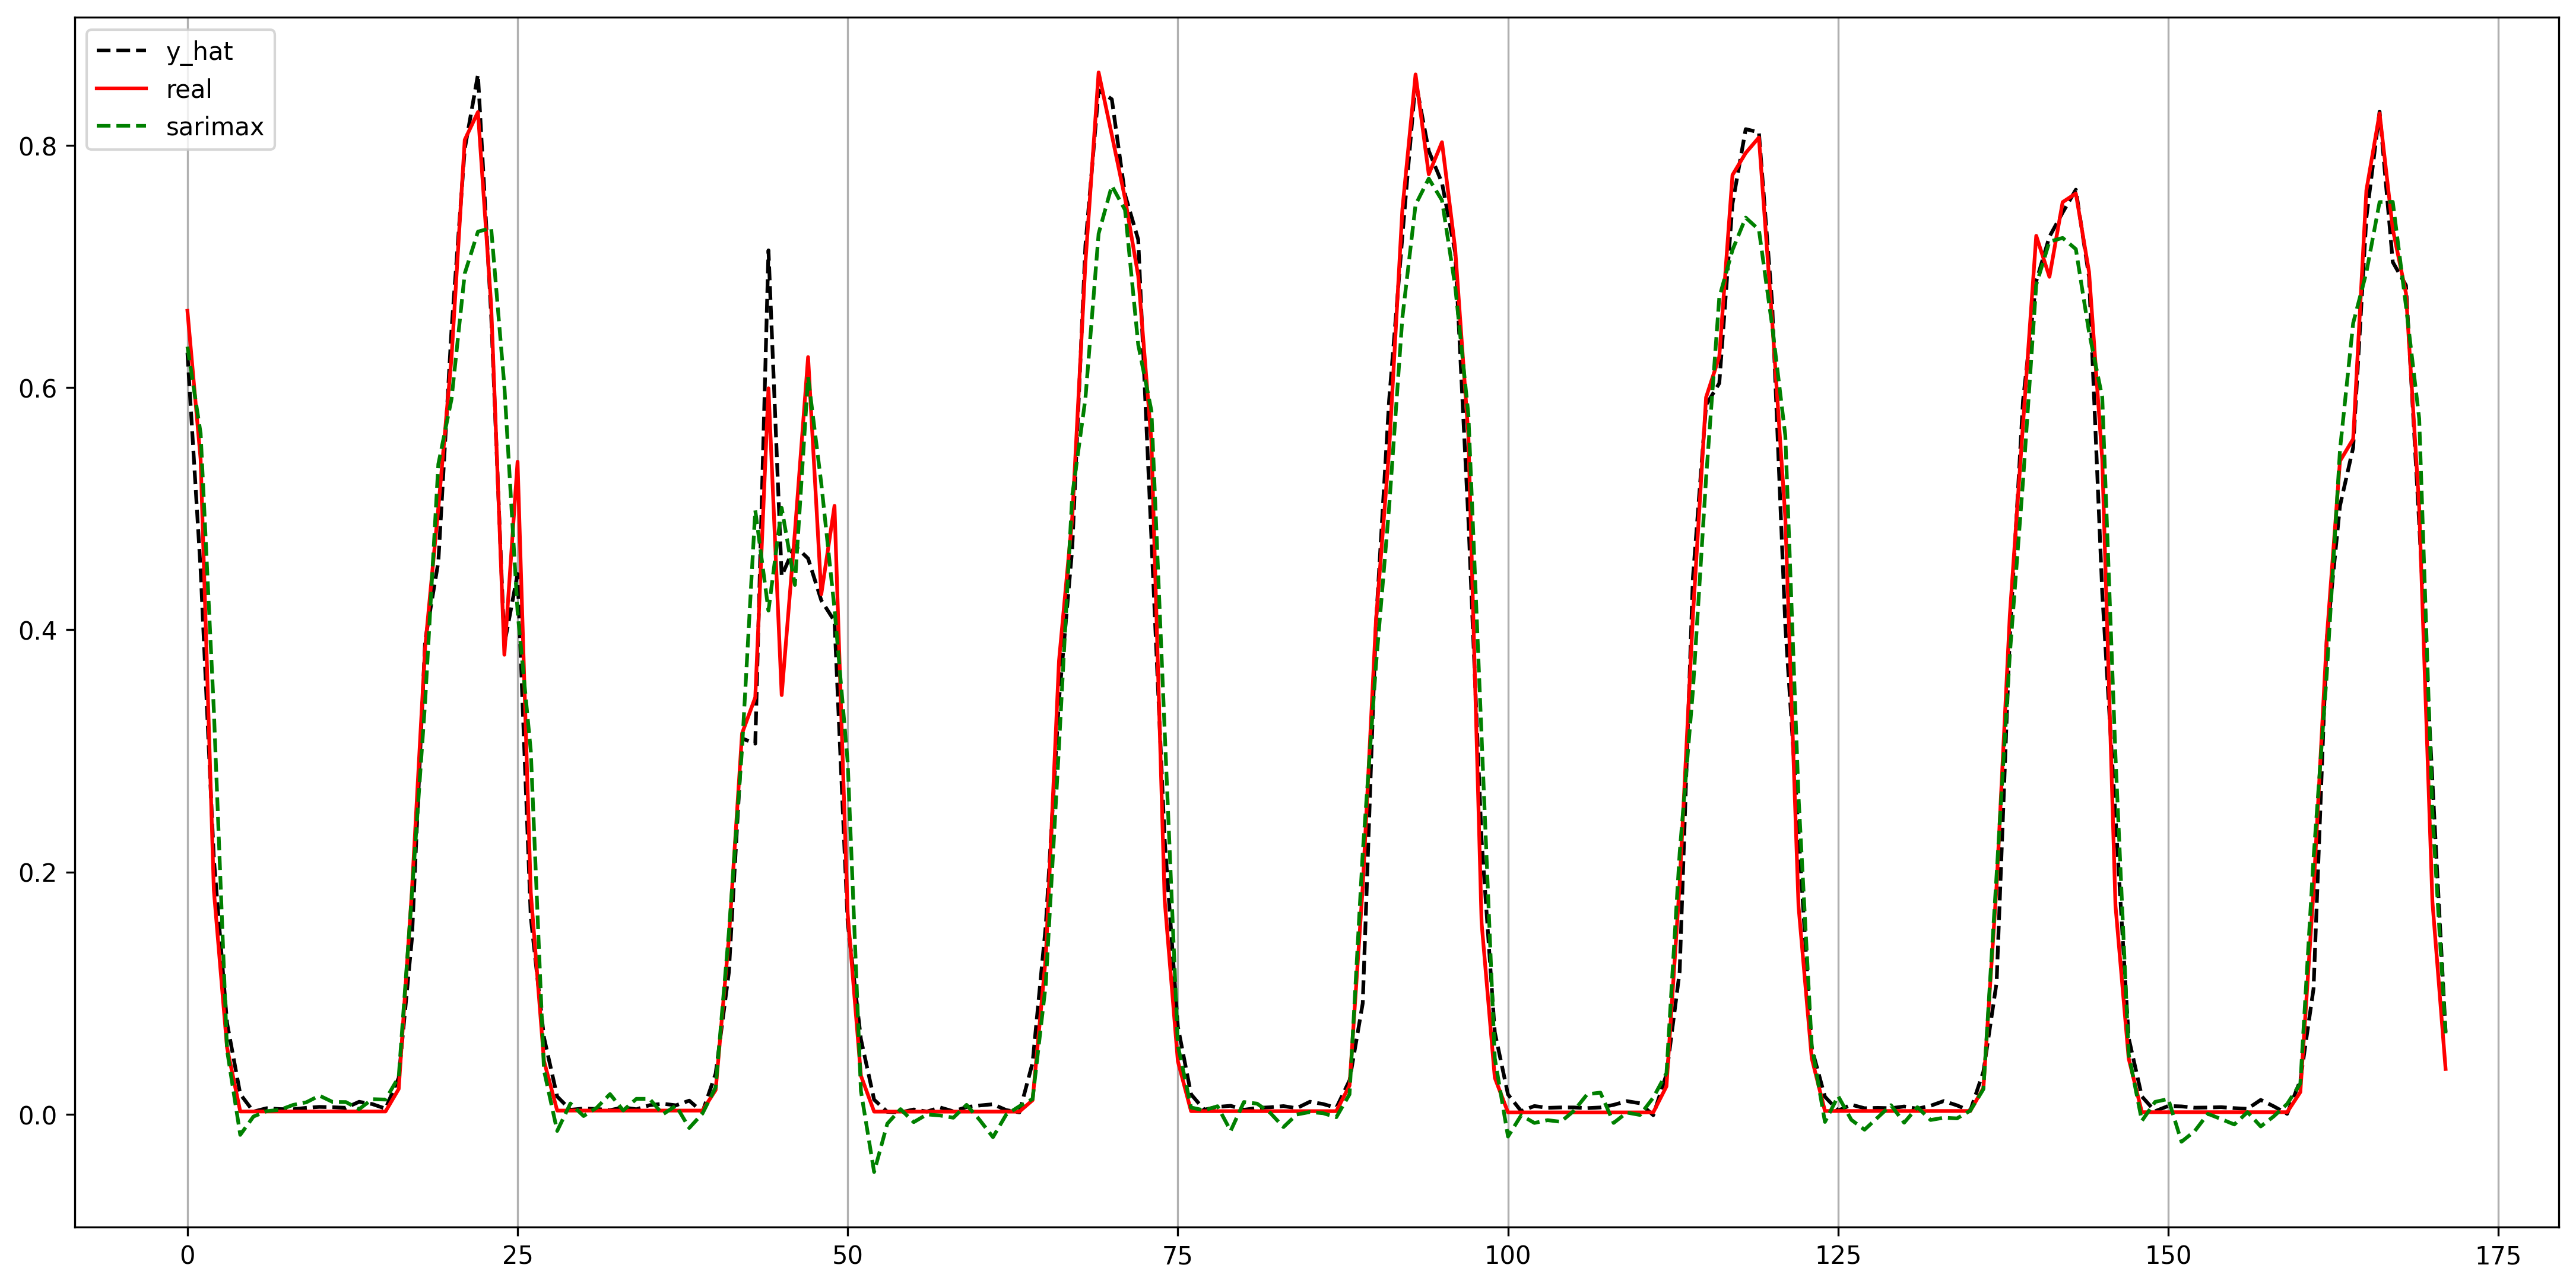

In [20]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

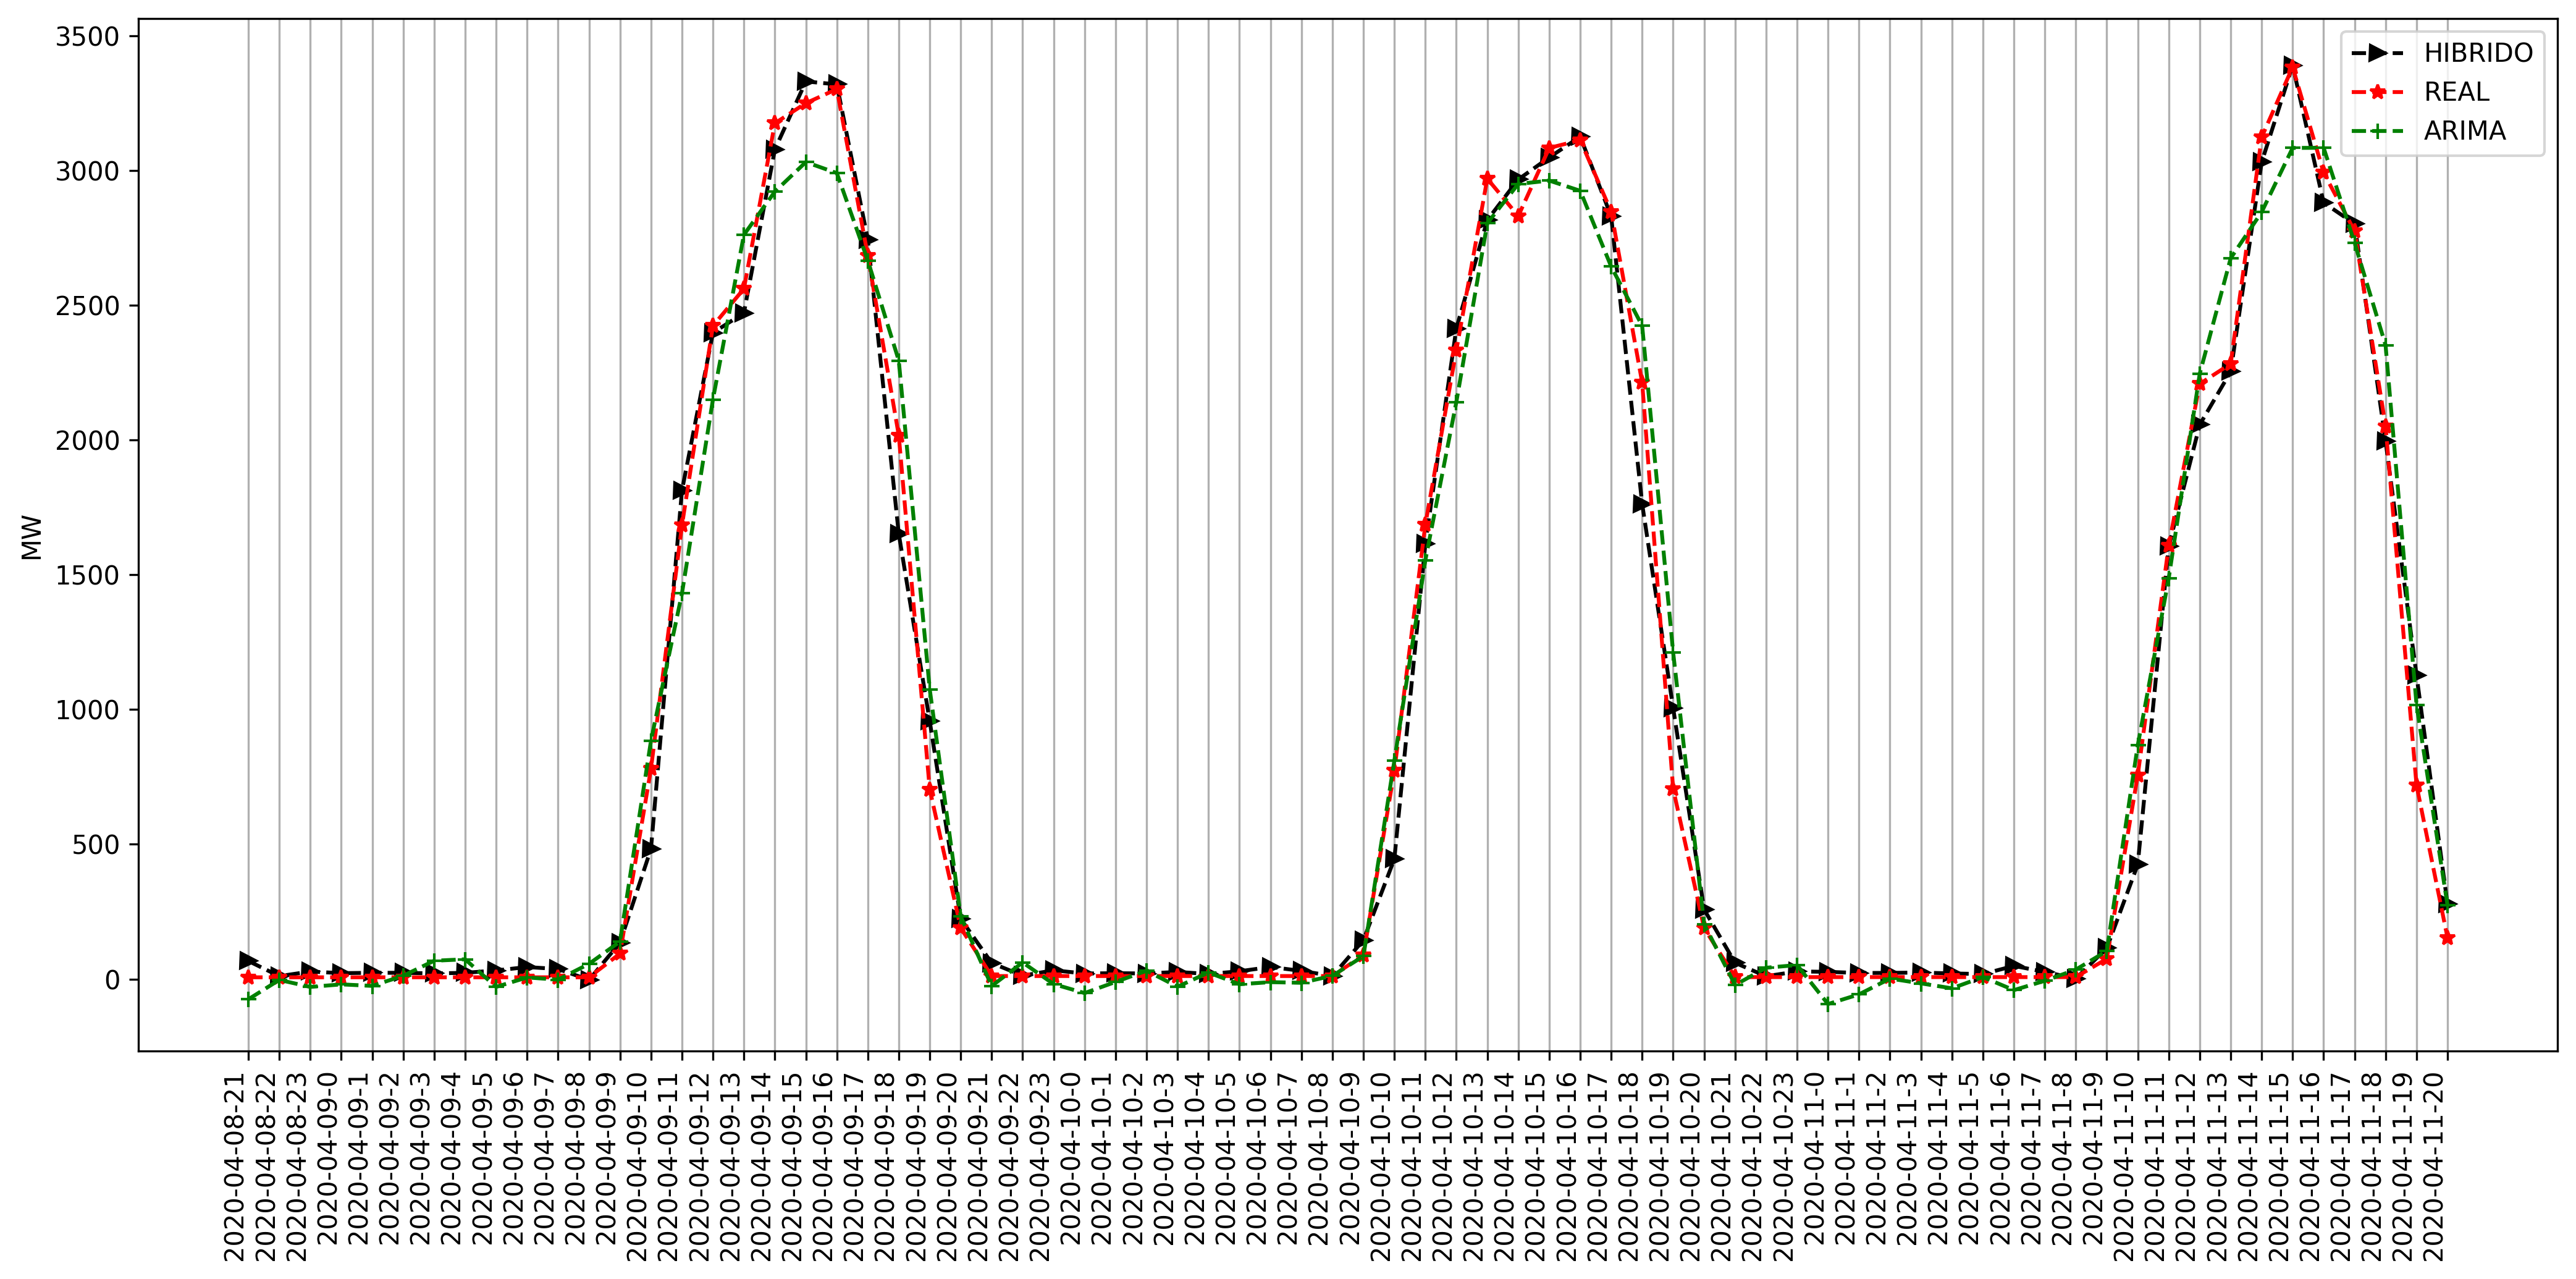

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.tight_layout()
plt.savefig('maceio_agmlpvrresidual_epoch3_pop12.png', dpi=300)

# Algoritmo AGEmsemble_Residual


[15, 10, 20, 1, VotingRegressor(estimators=[('SVR',
                             SVR(C=100, epsilon=0.1742386833465867,
                                 gamma='auto')),
                            ('BAG',
                             BaggingRegressor(max_samples=3, n_estimators=2)),
                            ('SGD', SGDRegressor()),
                            ('RFR',
                             RandomForestRegressor(max_depth=19,
                                                   min_samples_leaf=6,
                                                   min_weight_fraction_leaf=0.1315589727589142,
                                                   n_estimators=1)),
                            ('ADA', AdaBoostRegressor(n_estimators=38)),
                            ('LR', LinearRegression())]), VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=4,
                        

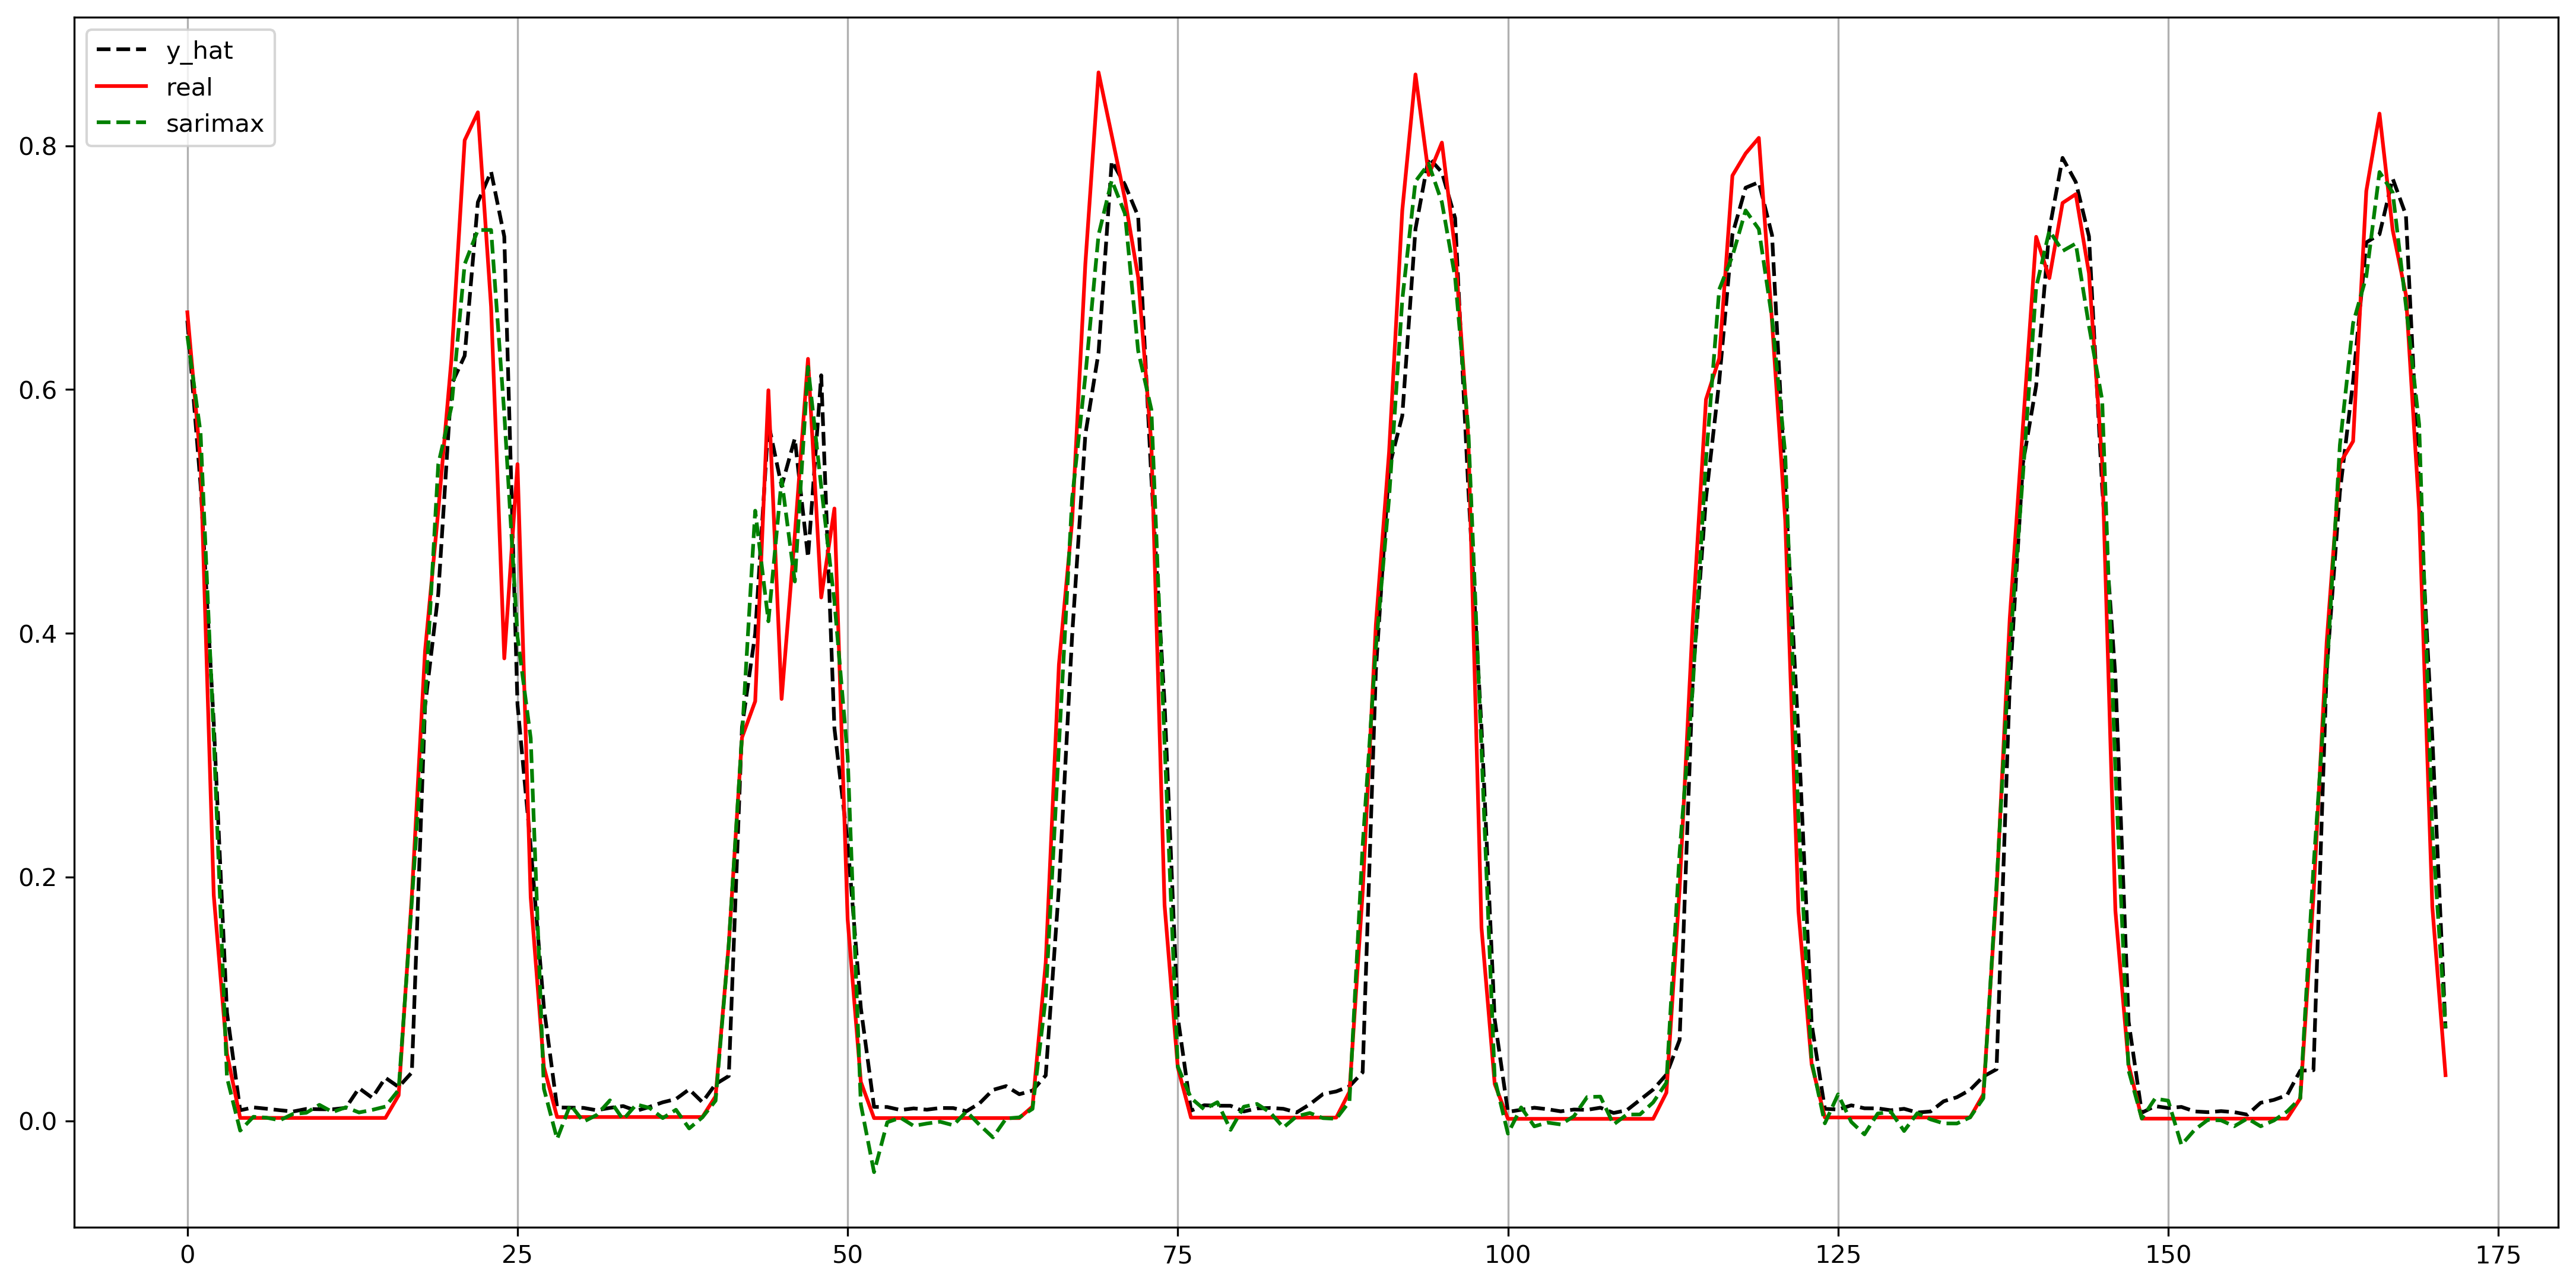

In [11]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

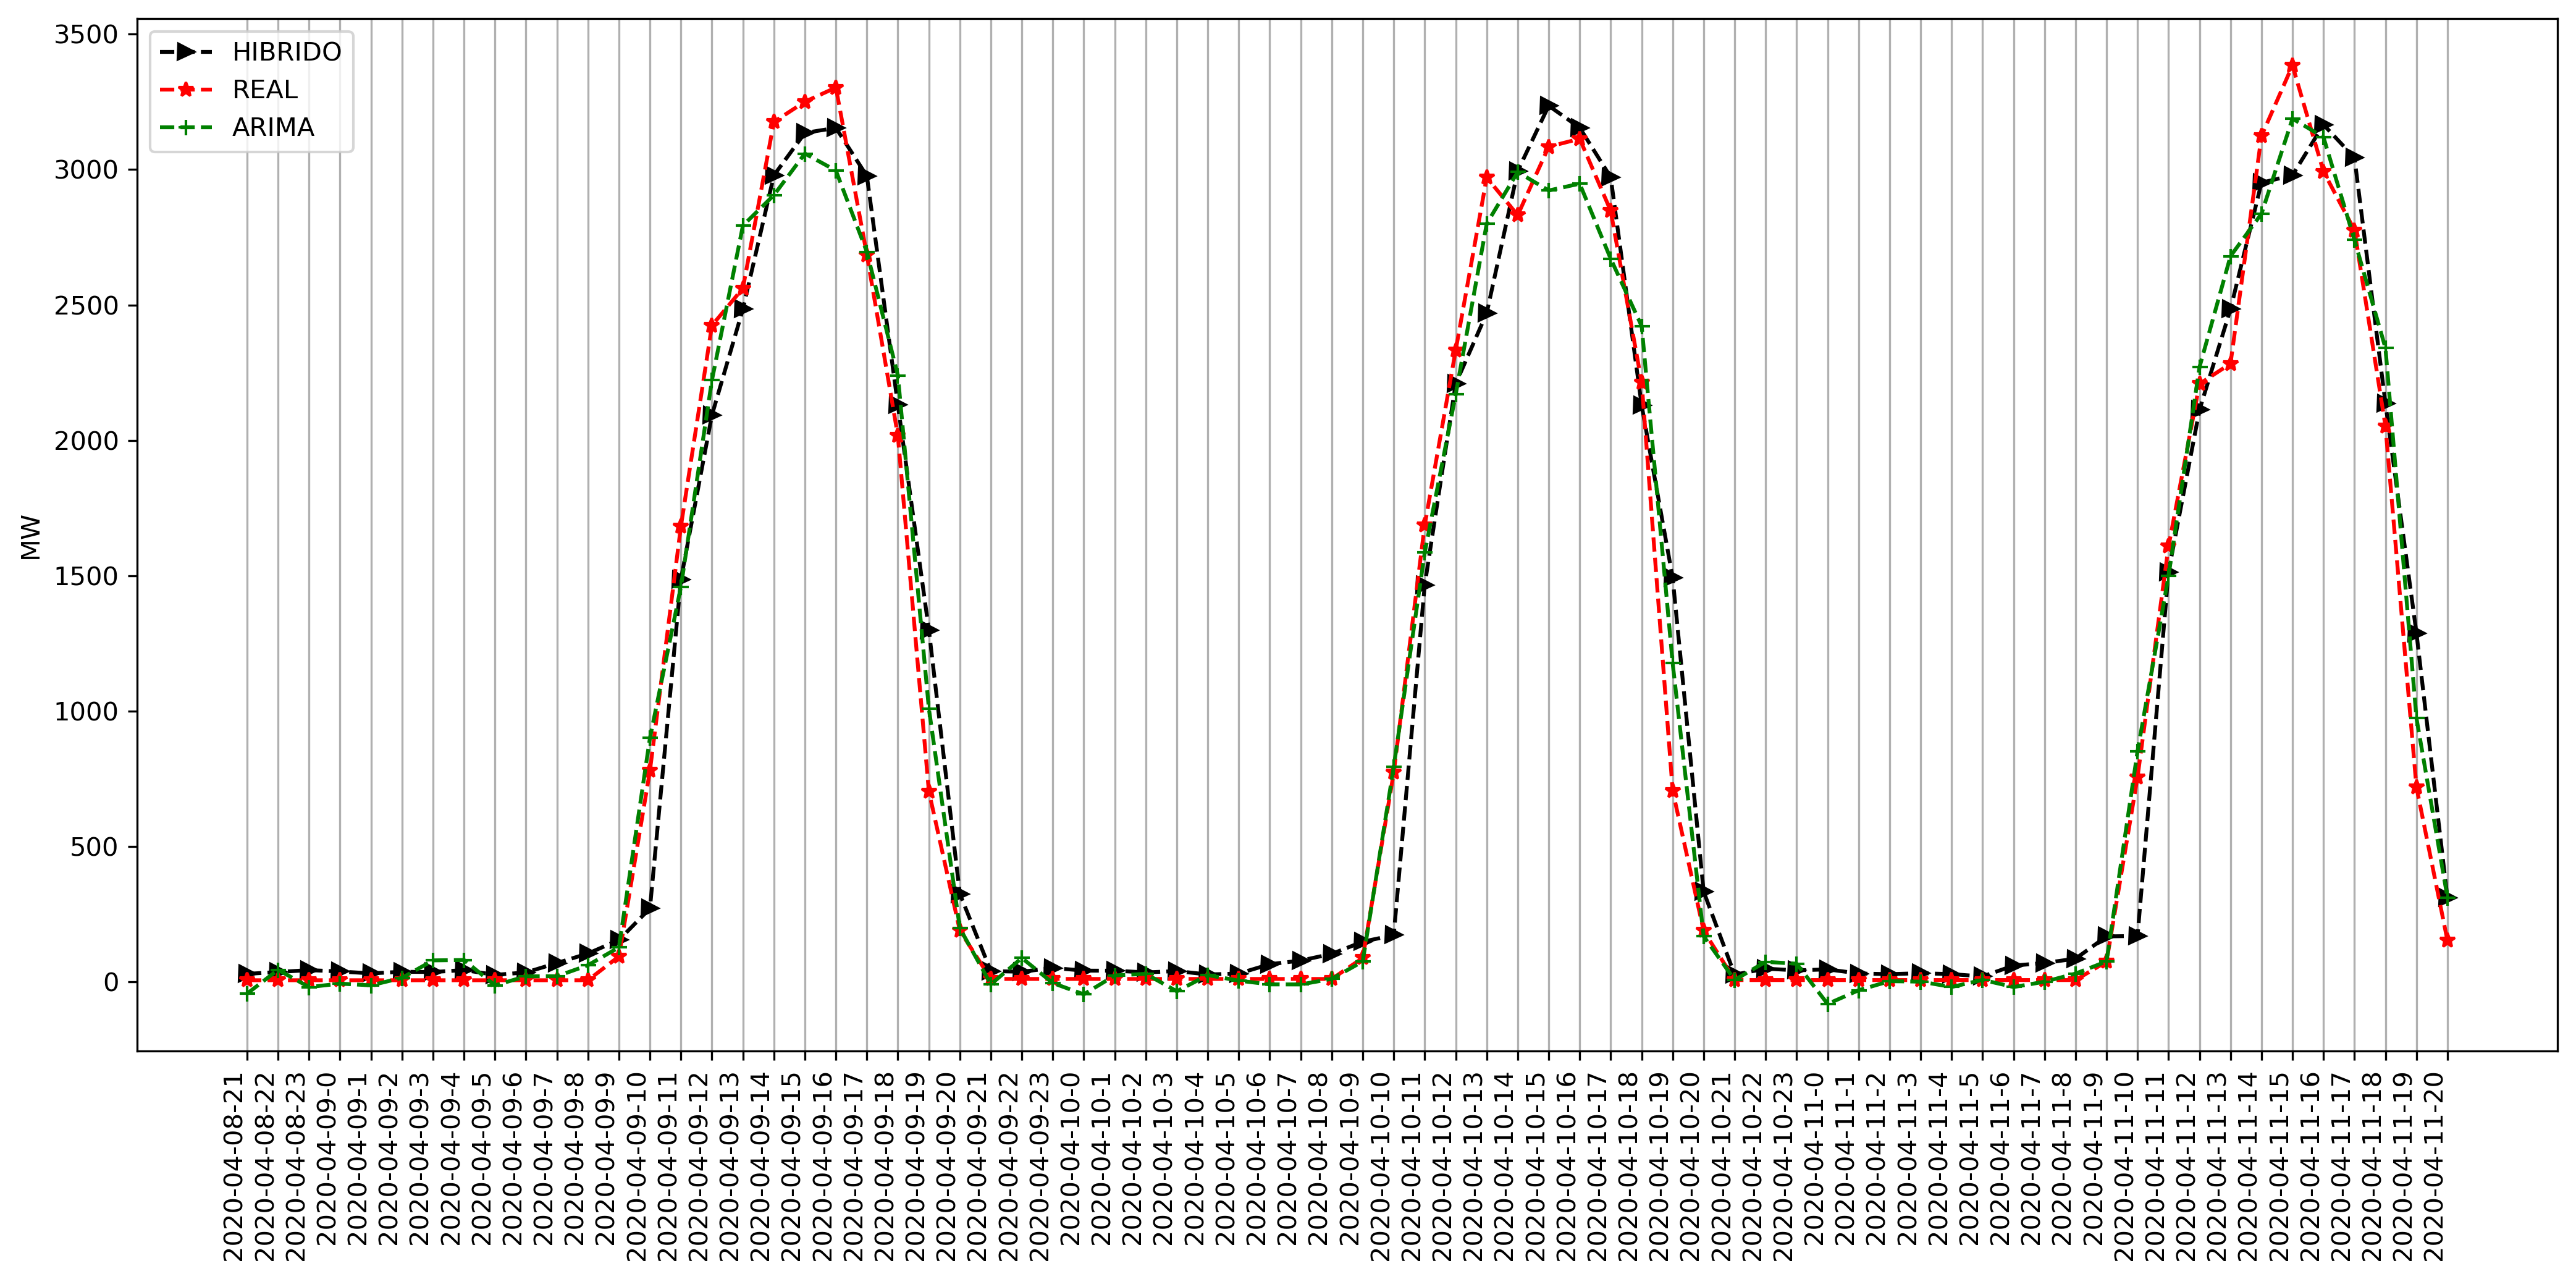

In [14]:
## Análise Resultados

In [ ]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()